# Lab 5 – Part 1: Image Alignment with RANSAC (Jupyter‐Style)

**Mục tiêu của Part 1**  
1. Match features giữa hai ảnh.  
2. Dùng RANSAC để ước lượng phép biến đổi Homography.  
3. Warp (align) ảnh A sang coordinate của ảnh B.  
4. Hiển thị kết quả (cả phần match inliers và ảnh warped).




Part 1:  Image Alignment with RANSAC


In [4]:
!pip install numpy matplotlib jupyterlab
!pip install opencv-python           
!pip install opencv-contrib-python     


   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
    --------------------------------------- 0.3/12.3 MB ? eta -:--:--
    --------------------------------------- 0.3/12.3 MB ? eta -:--:--
    --------------------------------------- 0.3/12.3 MB ? eta -:--:--
    --------------------------------------- 0.3/12.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.3 MB 328.9 kB/s eta 0:00:36
   - ------

Cell 1: Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đảm bảo hiển thị hình inline trong Jupyter
%matplotlib inline

print("Thư viện đã import thành công.")

Thư viện đã import thành công.


Cell 2: Định nghĩa hàm load và hiển thị ảnh đầu vào

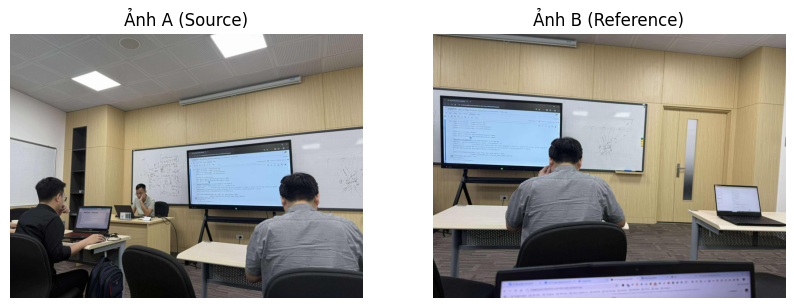

In [2]:
# Cell 2: Hàm load và hiển thị hai ảnh A và B
def load_and_show_images(pathA: str, pathB: str):
    """
    Đọc hai ảnh từ đường dẫn, chuyển sang màu RGB để hiển thị qua matplotlib.
    Trả về ảnh BGR ban đầu (để xử lý), và cũng trả về ảnh RGB để show.
    """
    # Đọc ảnh
    imgA_bgr = cv2.imread(pathA, cv2.IMREAD_COLOR)
    imgB_bgr = cv2.imread(pathB, cv2.IMREAD_COLOR)
    if imgA_bgr is None or imgB_bgr is None:
        raise IOError("Không thể đọc ảnh. Kiểm tra đường dẫn .")
    
    # Chuyển BGR -> RGB để hiển thị đẹp với matplotlib
    imgA_rgb = cv2.cvtColor(imgA_bgr, cv2.COLOR_BGR2RGB)
    imgB_rgb = cv2.cvtColor(imgB_bgr, cv2.COLOR_BGR2RGB)
    
    # Hiển thị hai ảnh cạnh nhau
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Ảnh A (Source)")
    plt.axis('off')
    plt.imshow(imgA_rgb)
    
    plt.subplot(1,2,2)
    plt.title("Ảnh B (Reference)")
    plt.axis('off')
    plt.imshow(imgB_rgb)
    plt.show()
    
    return imgA_bgr, imgB_bgr, imgA_rgb, imgB_rgb

pathA = r"D:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 5\Data\Part1\a.jpg"    
pathB = r"D:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 5\Data\Part1\b.jpg"    

imgA_bgr, imgB_bgr, imgA_rgb, imgB_rgb = load_and_show_images(pathA, pathB)


Cell 3: Khởi tạo Detector/Descriptor (ORB hoặc SIFT)

In [3]:
# Cell 3: Hàm khởi tạo detector/descriptor và tìm keypoints + descriptors
def detect_and_compute(img_gray, detector_type='ORB', max_features=3000):
    """
    img_gray: ảnh xám (grayscale)
    detector_type: 'ORB' hoặc 'SIFT'
    max_features: chỉ áp dụng khi detector_type='ORB'
    
    Trả về:
      keypoints, descriptors
    """
    if detector_type == 'SIFT':
        sift = cv2.SIFT_create()
        kpts, desc = sift.detectAndCompute(img_gray, None)
        norm = cv2.NORM_L2
        print(f"[INFO] Dùng SIFT: tìm được {len(kpts)} keypoints.")
    else:
        orb = cv2.ORB_create(nfeatures=max_features)
        kpts, desc = orb.detectAndCompute(img_gray, None)
        norm = cv2.NORM_HAMMING
        print(f"[INFO] Dùng ORB: tìm được {len(kpts)} keypoints.")
    
    return kpts, desc, norm

# Ví dụ gọi hàm:
imgA_gray = cv2.cvtColor(imgA_bgr, cv2.COLOR_BGR2GRAY)
imgB_gray = cv2.cvtColor(imgB_bgr, cv2.COLOR_BGR2GRAY)

kptsA, descA, normA = detect_and_compute(imgA_gray, detector_type='ORB', max_features=3000)
kptsB, descB, normB = detect_and_compute(imgB_gray, detector_type='ORB', max_features=3000)


[INFO] Dùng ORB: tìm được 3000 keypoints.
[INFO] Dùng ORB: tìm được 3000 keypoints.


Cell 4: Feature Matching + Ratio Test

In [4]:
# Cell 4: Hàm match descriptors và áp Lowe's ratio test
def match_features(descA, descB, norm_type, ratio_thresh=0.75):
    """
    descA, descB: descriptors (numpy arrays)
    norm_type: cv2.NORM_HAMMING (ORB) hoặc cv2.NORM_L2 (SIFT)
    ratio_thresh: ngưỡng Lowe's ratio test
    Trả về: danh sách good_matches (mỗi phần tử là cv2.DMatch)
    """
    bf = cv2.BFMatcher(norm_type, crossCheck=False)
    # knnMatch k=2 để áp ratio test
    knn_matches = bf.knnMatch(descA, descB, k=2)
    
    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    print(f"[INFO] Sau ratio test: {len(good_matches)} matches tốt.")
    return good_matches

# Ví dụ gọi hàm:
good_matches = match_features(descA, descB, normA, ratio_thresh=0.75)


[INFO] Sau ratio test: 154 matches tốt.


Cell 5: Ước lượng Homography bằng RANSAC

In [5]:
# Cell 5: Hàm tính Homography với RANSAC
def estimate_homography_ransac(kptsA, kptsB, good_matches, ransac_thresh=3.0):
    """
    kptsA: keypoints của ảnh A
    kptsB: keypoints của ảnh B
    good_matches: danh sách các cv2.DMatch đã lọc bằng ratio test
    ransac_thresh: ngưỡng reprojection error (pixel) cho RANSAC
    
    Trả về:
      H (3x3 homography matrix),
      mask (danh sách 0/1 xác định inlier/outlier),
      ptsA_in, ptsB_in (mảng 2D float32 của những point đã chọn)
    """
    if len(good_matches) < 4:
        raise ValueError("Quá ít matches để tính Homography (cần >= 4).")
    
    # Chuẩn bị mảng điểm tương ứng
    ptsA = np.float32([kptsA[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    ptsB = np.float32([kptsB[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransac_thresh)
    if H is None:
        raise RuntimeError("findHomography trả về None. Tăng ransac_thresh thử.")
    
    mask = mask.ravel().tolist()  # chuyển shape (N,1) thành list (N,)
    inlier_count = sum(mask)
    print(f"[INFO] RANSAC inliers: {inlier_count}/{len(good_matches)}")
    
    # Lấy mảng point của những inlier để vẽ sau
    ptsA_in = ptsA[mask==1].reshape(-1,2) if isinstance(mask, np.ndarray) else np.float32([kptsA[good_matches[i].queryIdx].pt for i in range(len(good_matches)) if mask[i]==1])
    ptsB_in = ptsB[mask==1].reshape(-1,2) if isinstance(mask, np.ndarray) else np.float32([kptsB[good_matches[i].trainIdx].pt for i in range(len(good_matches)) if mask[i]==1])
    
    return H, mask, ptsA, ptsB

# Ví dụ gọi hàm:
H, mask, ptsA_all, ptsB_all = estimate_homography_ransac(kptsA, kptsB, good_matches, ransac_thresh=3.0)


[INFO] RANSAC inliers: 96/154


Cell 6: Vẽ các Inlier Matches và Outlier Matches

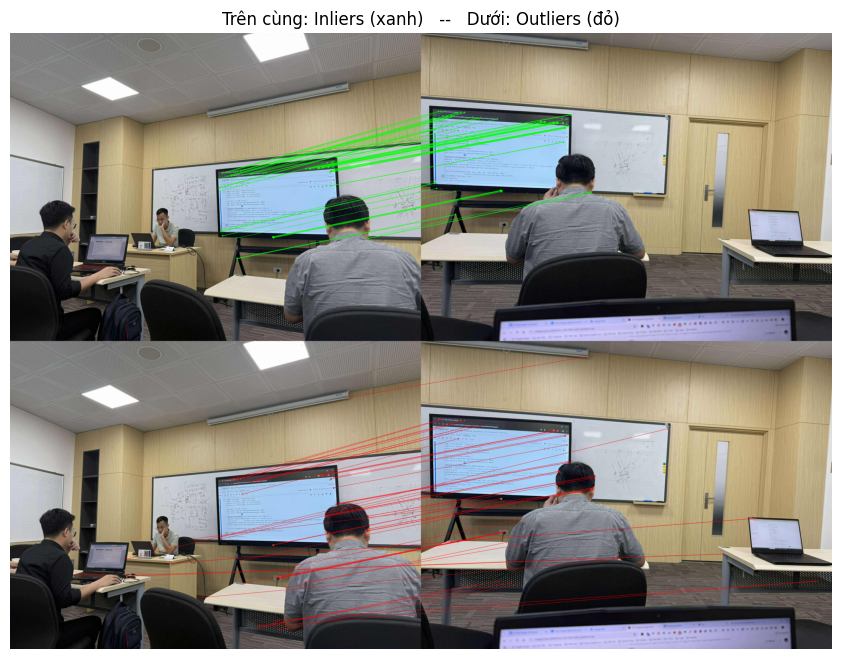

In [6]:
# Cell 6: Hàm vẽ inlier/outlier matches
def draw_inliers_outliers(imgA_bgr, imgB_bgr, kptsA, kptsB, good_matches, mask):
    """
    Vẽ inlier (màu xanh) và outlier (màu đỏ) giữa hai ảnh.
    mask: list/array 0/1 tương ứng với good_matches
    """
    inlier_matches = []
    outlier_matches = []
    for i, m in enumerate(good_matches):
        if mask[i]:
            inlier_matches.append(m)
        else:
            outlier_matches.append(m)
    
    # Vẽ inliers
    inlier_img = cv2.drawMatches(
        imgA_bgr, kptsA,
        imgB_bgr, kptsB,
        inlier_matches, None,
        matchColor=(0,255,0),  # xanh
        singlePointColor=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    # Vẽ outliers
    outlier_img = cv2.drawMatches(
        imgA_bgr, kptsA,
        imgB_bgr, kptsB,
        outlier_matches, None,
        matchColor=(0,0,255),  # đỏ
        singlePointColor=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    # Ghép hai hình inlier + outlier xuống chung để dễ so sánh
    combined = np.vstack((inlier_img, outlier_img))
    
    plt.figure(figsize=(12, 8))
    plt.title("Trên cùng: Inliers (xanh)   --   Dưới: Outliers (đỏ)")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.show()

# Ví dụ gọi hàm:
draw_inliers_outliers(imgA_bgr, imgB_bgr, kptsA, kptsB, good_matches, mask)


Cell 7: Warp (Align) Ảnh A sang Ảnh B

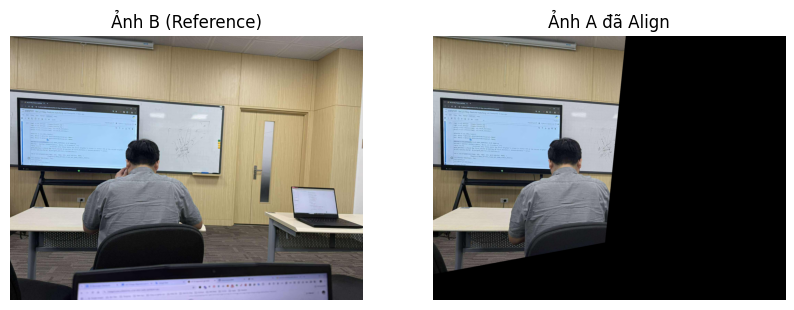

In [7]:
# Cell 7: Hàm warp Perspective
def warp_image(imgA_bgr, imgB_bgr, H):
    """
    Áp homography H để warp imgA sang hệ tọa độ của imgB.
    Trả về ảnh đã warp (kích cỡ bằng imgB).
    """
    hB, wB = imgB_bgr.shape[:2]
    warped_A = cv2.warpPerspective(imgA_bgr, H, (wB, hB))
    return warped_A

# Ví dụ gọi hàm:
aligned_A = warp_image(imgA_bgr, imgB_bgr, H)

# Hiển thị ảnh B và ảnh A đã align
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Ảnh B (Reference)")
plt.axis('off')
plt.imshow(cv2.cvtColor(imgB_bgr, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title("Ảnh A đã Align")
plt.axis('off')
plt.imshow(cv2.cvtColor(aligned_A, cv2.COLOR_BGR2RGB))
plt.show()


Cell 8: Overlay Hai Ảnh để Kiểm tra Kết Quả

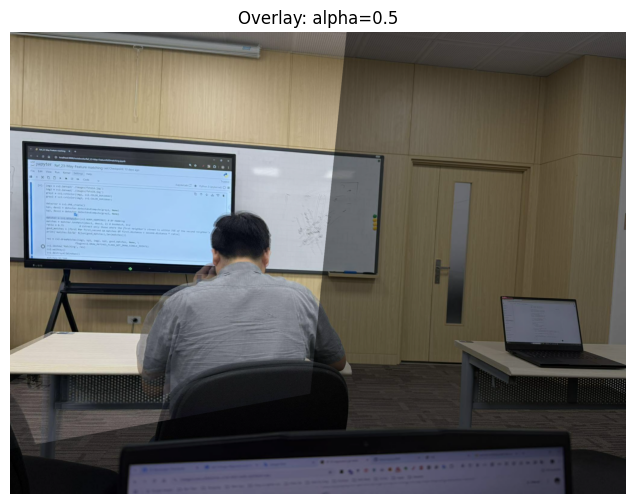

In [8]:
# Cell 8: Hàm tạo overlay (blend 50/50) để trực quan kiểm tra alignment
def overlay_images(imgA_warped, imgB_bgr, alpha=0.5):
    """
    Tạo ảnh overlay = alpha*imgA_warped + (1-alpha)*imgB_bgr
    alpha: trọng số của ảnh A đã warp
    """
    overlay = cv2.addWeighted(imgA_warped, alpha, imgB_bgr, 1-alpha, 0)
    plt.figure(figsize=(8,6))
    plt.title(f"Overlay: alpha={alpha}")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.show()
    return overlay

# Ví dụ gọi hàm:
overlay_img = overlay_images(aligned_A, imgB_bgr, alpha=0.5)


Part 2: Image Stitching


**Mục tiêu của Part 2**  
1. Ghép nối (stitch) nhiều ảnh có phần chồng lấn (overlap) thành một ảnh toàn cảnh liền mạch.  
2. Áp dụng vào tình huống như ghi chú trên **whiteboard** hoặc **scanning tài liệu khổ lớn**.  
3. Chọn phương pháp phù hợp để detect feature, match, ước lượng homography và blending để có ảnh kết quả “seamless” – không thấy vết nối.  

Cell 1: Imports cơ bản

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Cell 2: Định nghĩa hàm load nhiều ảnh và hiển thị tổng quan

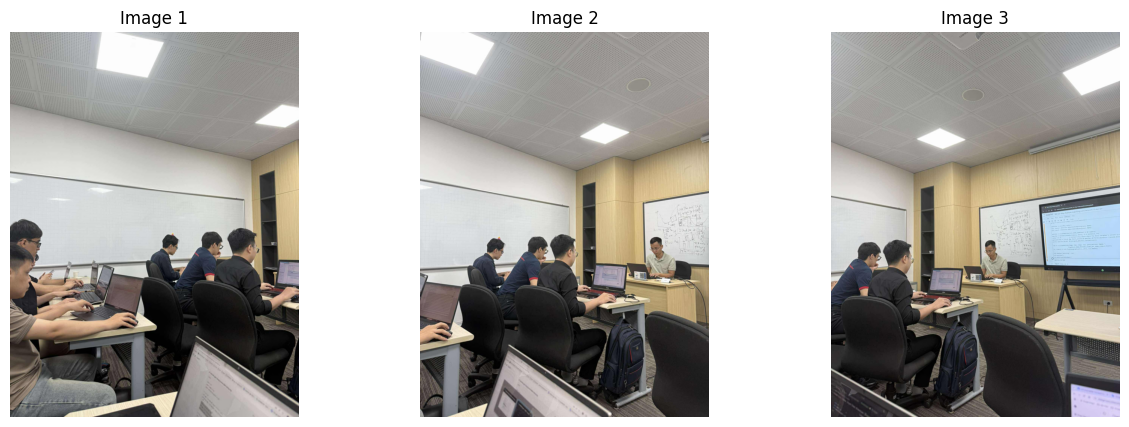

In [10]:
# Cell 2: Hàm load list ảnh và hiển thị preview
def load_and_show_images_list(image_paths):
    """
    Đọc một list đường dẫn ảnh, chuyển sang RGB để hiển thị qua matplotlib.
    Trả về list ảnh BGR (để xử lý).
    """
    imgs_bgr = []
    plt.figure(figsize=(15, 5))
    n = len(image_paths)
    for i, path in enumerate(image_paths):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise IOError(f"Không thể đọc ảnh: {path}")
        imgs_bgr.append(img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, n, i+1)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        plt.imshow(img_rgb)
    plt.show()
    return imgs_bgr

paths = [
    r"D:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 5\Data\Part2\a.jpg",
    r"D:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 5\Data\Part2\b.jpg",
    r"D:\MSE\HomeWork\Ky 2\IVP501\Test\Lab 5\Data\Part2\c.jpg"
]
imgs_bgr = load_and_show_images_list(paths)


Cell 3: Định nghĩa hàm detect & describe features (ORB hoặc SIFT)

In [11]:
# Cell 3: Hàm detect & compute descriptors cho một ảnh
def detect_and_compute(img_bgr, detector_type='ORB', max_features=3000):
    """
    img_bgr: ảnh màu (BGR)
    detector_type: 'ORB' hoặc 'SIFT'
    max_features: chỉ áp dụng khi ORB
    
    Trả về:
      keypoints, descriptors, norm_type
    """
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    if detector_type == 'SIFT':
        sift = cv2.SIFT_create()
        kpts, desc = sift.detectAndCompute(img_gray, None)
        norm_type = cv2.NORM_L2
        print(f"[INFO] SIFT: {len(kpts)} keypoints found.")
    else:
        orb = cv2.ORB_create(nfeatures=max_features)
        kpts, desc = orb.detectAndCompute(img_gray, None)
        norm_type = cv2.NORM_HAMMING
        print(f"[INFO] ORB: {len(kpts)} keypoints found.")
    
    return kpts, desc, norm_type

# Thử chạy cho tất cả ảnh
keypoints_list = []
descriptors_list = []
norms = []
for i, img in enumerate(imgs_bgr):
    kpts, desc, norm = detect_and_compute(img, detector_type='ORB', max_features=3000)
    keypoints_list.append(kpts)
    descriptors_list.append(desc)
    norms.append(norm)


[INFO] ORB: 3000 keypoints found.
[INFO] ORB: 3000 keypoints found.
[INFO] ORB: 3000 keypoints found.


Cell 4: Hàm match features giữa hai ảnh liên tiếp (ratio test)

In [12]:
# Cell 4: Hàm match descriptors giữa ảnh i và i+1
def match_features(descA, descB, norm_type, ratio_thresh=0.75):
    """
    descA, descB: descriptors của hai ảnh
    norm_type: cv2.NORM_HAMMING (ORB) hoặc cv2.NORM_L2 (SIFT)
    ratio_thresh: ngưỡng Lowe's ratio test (0.7–0.8 thường ổn)
    
    Trả về: danh sách good_matches (cv2.DMatch)
    """
    bf = cv2.BFMatcher(norm_type, crossCheck=False)
    knn_matches = bf.knnMatch(descA, descB, k=2)
    
    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    print(f"[INFO] Found {len(good_matches)} good matches.")
    return good_matches

# Thí dụ: match img1 và img2
good_matches_01 = match_features(descriptors_list[0], descriptors_list[1], norms[0], ratio_thresh=0.75)
# match img2 và img3
good_matches_12 = match_features(descriptors_list[1], descriptors_list[2], norms[1], ratio_thresh=0.75)


[INFO] Found 365 good matches.
[INFO] Found 790 good matches.


Cell 5: Ước lượng Homography với RANSAC cho từng cặp liên tiếp

In [13]:
# Cell 5: Hàm estimate homography (img i -> img j) dùng RANSAC
def estimate_homography(kptsA, kptsB, good_matches, ransac_thresh=3.0):
    """
    kptsA, kptsB: keypoints của ảnh A, B
    good_matches: danh sách match sau ratio test
    ransac_thresh: ngưỡng reprojection error cho RANSAC
    
    Trả về:
      H (3x3 homography),
      mask_inliers (list 0/1), 
      ptsA, ptsB (mảng 2D float32 của tất cả good matches)
    """
    if len(good_matches) < 4:
        raise ValueError("Quá ít matches (cần >=4) để tính homography.")
    
    # Chuẩn bị mảng điểm
    ptsA = np.float32([kptsA[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    ptsB = np.float32([kptsB[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransac_thresh)
    if H is None:
        raise RuntimeError("findHomography trả về None. Thử tăng ransac_thresh.")
    
    mask = mask.ravel().tolist()
    inlier_count = sum(mask)
    print(f"[INFO] RANSAC inliers: {inlier_count}/{len(good_matches)}")
    return H, mask, ptsA, ptsB

# Tính H(0->1) và H(1->2)
H_01, mask_01, pts01_A, pts01_B = estimate_homography(keypoints_list[0], keypoints_list[1], good_matches_01, ransac_thresh=3.0)
H_12, mask_12, pts12_A, pts12_B = estimate_homography(keypoints_list[1], keypoints_list[2], good_matches_12, ransac_thresh=3.0)


[INFO] RANSAC inliers: 193/365
[INFO] RANSAC inliers: 443/790


Cell 6: Vẽ inliers/outliers để kiểm tra chất lượng Homography

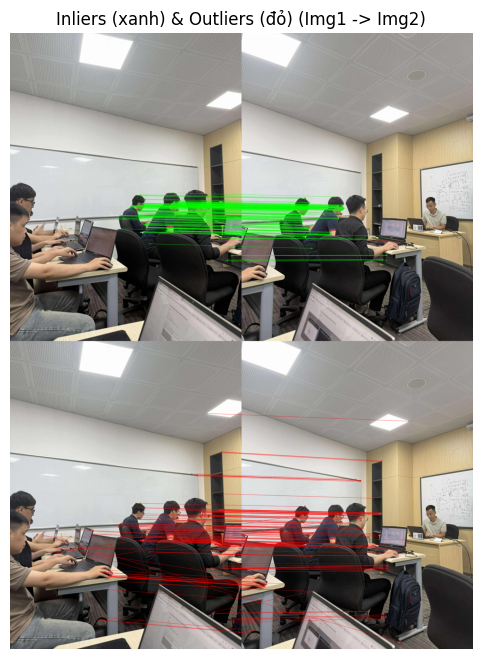

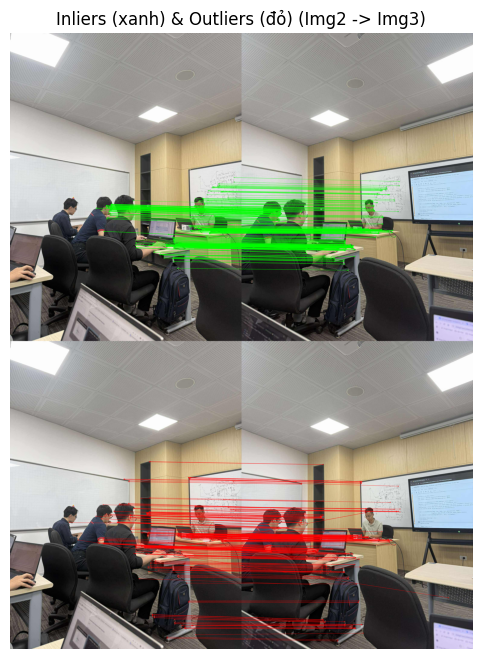

In [14]:
# Cell 6: Hàm vẽ inliers/outliers cho cặp ảnh i -> j
def draw_inliers_outliers(imgA_bgr, imgB_bgr, kptsA, kptsB, good_matches, mask, title_suffix=""):
    """
    imgA_bgr, imgB_bgr: ảnh BGR gốc
    kptsA, kptsB: keypoints
    good_matches: danh sách cv2.DMatch
    mask: list 0/1 đánh dấu inlier/outlier
    title_suffix: chuỗi để thêm vào title của plot
    """
    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
    outlier_matches = [good_matches[i] for i in range(len(good_matches)) if not mask[i]]
    
    inlier_img = cv2.drawMatches(
        imgA_bgr, kptsA, imgB_bgr, kptsB, inlier_matches, None,
        matchColor=(0,255,0), singlePointColor=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    outlier_img = cv2.drawMatches(
        imgA_bgr, kptsA, imgB_bgr, kptsB, outlier_matches, None,
        matchColor=(0,0,255), singlePointColor=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    combined = np.vstack((inlier_img, outlier_img))
    plt.figure(figsize=(12,8))
    plt.title(f"Inliers (xanh) & Outliers (đỏ) {title_suffix}")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.show()

# Vẽ cho cặp 0->1
draw_inliers_outliers(imgs_bgr[0], imgs_bgr[1], keypoints_list[0], keypoints_list[1], good_matches_01, mask_01, title_suffix="(Img1 -> Img2)")

# Vẽ cho cặp 1->2
draw_inliers_outliers(imgs_bgr[1], imgs_bgr[2], keypoints_list[1], keypoints_list[2], good_matches_12, mask_12, title_suffix="(Img2 -> Img3)")


Cell 7: Tính Homography “tổng hợp” đến ảnh reference

In [15]:
# Cell 7: Tích lũy homography để đưa mọi ảnh về coordinate của ảnh reference (ví dụ: ảnh index=1)
def accumulate_homographies(homographies, ref_index):
    """
    homographies: list H_i_j tương ứng với H[i->i+1]
      Ví dụ homographies = [H_01, H_12, H_23, ...]
    ref_index: index của ảnh làm reference (ví dụ 1 nếu ảnh2 là reference)
    
    Trả về:
      H_to_ref: list ma trận H từng ảnh -> ref ảnh
    """
    n = len(homographies) + 1  # số ảnh gốc
    # Khởi tạo H_to_ref với identity cho tất cả
    H_to_ref = [np.eye(3) for _ in range(n)]
    
    # Từ ref_index xuống các ảnh trước
    for i in range(ref_index, 0, -1):
        # H[i-1 -> i] = homographies[i-1]
        H_to_ref[i-1] = H_to_ref[i].dot(np.linalg.inv(homographies[i-1]))
    
    # Từ ref_index lên các ảnh sau
    for i in range(ref_index, n-1):
        # H[i+1 -> i] = inv(homographies[i])
        H_to_ref[i+1] = H_to_ref[i].dot(homographies[i])
    
    return H_to_ref

# Ví dụ: chúng ta có 3 ảnh, homographies = [H_01, H_12], 
# chúng ta chọn ảnh index=1 (tức ảnh2) làm reference
homographies = [H_01, H_12]
H_to_ref = accumulate_homographies(homographies, ref_index=1)

for idx, H in enumerate(H_to_ref):
    print(f"H to ref (img{idx}->img1):\n{H}\n")


H to ref (img0->img1):
[[ 6.00486726e-01  7.23718045e-02  3.84162379e+02]
 [-2.47458965e-01  8.35974184e-01  7.79004664e+01]
 [-2.09932457e-04  3.12202652e-05  8.81115987e-01]]

H to ref (img1->img1):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

H to ref (img2->img1):
[[ 1.26415240e+00 -6.88851441e-02 -4.95032762e+02]
 [ 2.16505729e-01  1.05072903e+00 -8.76452649e+01]
 [ 2.17548218e-04 -6.65025047e-05  1.00000000e+00]]



Cell 8: Tính kích thước canvas panorama và tìm bounding box

In [16]:
# Cell 8: Hàm tìm bounding box warp của mỗi ảnh trên canvas
def get_transformed_corners(img, H):
    """
    img: ảnh BGR 
    H: homography 3x3 (ảnh -> coordinate reference)
    Trả về: tọa độ corners warped (4 hàng, 2 cột)
    """
    h, w = img.shape[:2]
    # 4 corner gốc: (0,0), (w,0), (w,h), (0,h)
    corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners, H)
    return warped_corners.reshape(-1,2)

# Tính các corners warped cho mỗi ảnh
all_corners = [get_transformed_corners(imgs_bgr[i], H_to_ref[i]) for i in range(len(imgs_bgr))]

# Kiểm tra min/max x, y để xác định kích thước canvas
all_points = np.vstack(all_corners)
xmin, ymin = np.min(all_points, axis=0)
xmax, ymax = np.max(all_points, axis=0)

print(f"xmin = {xmin}, ymin = {ymin}, xmax = {xmax}, ymax = {ymax}")

# Chúng ta cần dịch (translate) tất cả H_to_ref để đảm bảo xmin/ymin >= 0
# Tạo ma trận D translation: đưa xmin, ymin về (0,0)
tx = -xmin if xmin < 0 else 0
ty = -ymin if ymin < 0 else 0
print(f"Translation to apply: tx = {tx}, ty = {ty}")

# Ma trận chuyển: 
H_trans = np.array([[1,0,tx],
                    [0,1,ty],
                    [0,0,1]])

# Canvas width/height
canvas_width = int(xmax + tx)
canvas_height = int(ymax + ty)
print(f"Canvas size: width={canvas_width}, height={canvas_height}")


xmin = -736.4058837890625, ymin = -540.9312133789062, xmax = 2338.650634765625, ymax = 2389.720947265625
Translation to apply: tx = 736.4058837890625, ty = 540.9312133789062
Canvas size: width=3075, height=2930


Cell 9: Warp tất cả ảnh vào Canvas & Tạo masks

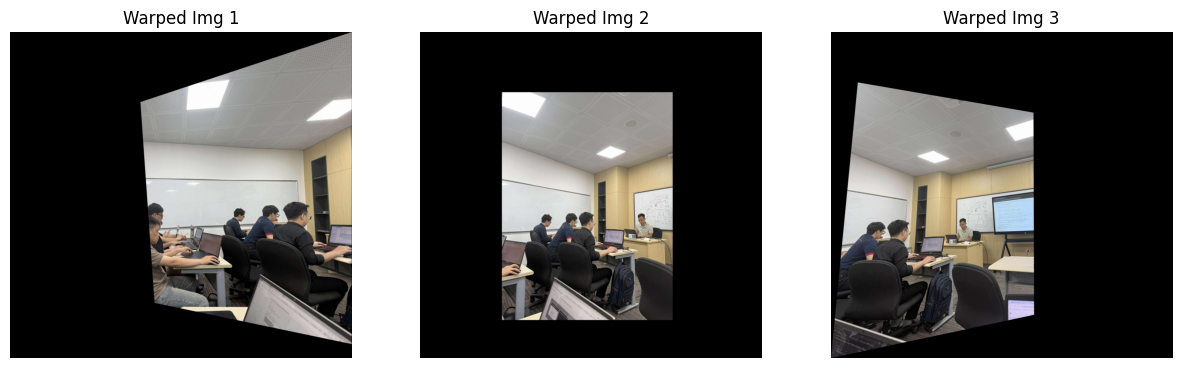

In [17]:
# Cell 9: Warp từng ảnh và tạo mask vùng valid (để blending)
def warp_images_to_canvas(imgs_bgr, H_to_ref, H_trans, canvas_size):
    """
    imgs_bgr: list ảnh gốc
    H_to_ref: list homography ảnh->reference
    H_trans: translation homography (để dịch canvas)
    canvas_size: (width, height)
    
    Trả về:
      warped_images: list ảnh đã warp vào canvas (same size)
      masks: list mask vùng valid (255 = valid, 0 = background)
    """
    width, height = canvas_size
    warped_images = []
    masks = []
    for i, img in enumerate(imgs_bgr):
        H_full = H_trans.dot(H_to_ref[i])  # Ảnh i -> ref -> dịch để canvas (tổng cộng)
        warped = cv2.warpPerspective(img, H_full, (width, height))
        warped_images.append(warped)
        
        # Tạo mask: warp ảnh trắng 255 để đánh dấu vùng valid
        mask = np.ones_like(img[:,:,0]) * 255  # ảnh grayscale trắng
        mask_warped = cv2.warpPerspective(mask, H_full, (width, height))
        masks.append(mask_warped)
    return warped_images, masks

# Gọi hàm warp
canvas_size = (canvas_width, canvas_height)
warped_images, masks = warp_images_to_canvas(imgs_bgr, H_to_ref, H_trans, canvas_size)

# Hiển thị từng ảnh warp trên canvas (xem tổng quan)
plt.figure(figsize=(15,5))
for i, wimg in enumerate(warped_images):
    plt.subplot(1, len(warped_images), i+1)
    plt.title(f"Warped Img {i+1}")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(wimg, cv2.COLOR_BGR2RGB))
plt.show()


Cell 10: Blending – Simple Linear Feathering

C:\Users\binhn\AppData\Local\Temp\ipykernel_9580\738263137.py:34: RuntimeWarning: invalid value encountered in divide
  acc_image / acc_weight_3ch,


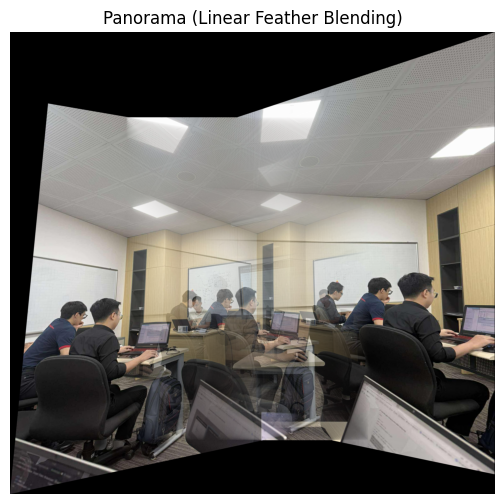

In [18]:
# Cell 10: Hàm linear feather blending giữa nhiều ảnh warped
def linear_blend(warped_images, masks):
    """
    warped_images: list các ảnh đã warp (BGR) cùng size
    masks: list mask vùng valid (0/255) cùng size
    
    Trả về:
      blended: ảnh panorama kết quả
    """
    # Chuyển sang float để tránh tràn số khi cộng trừ
    acc_image = np.zeros_like(warped_images[0], dtype=np.float32)
    acc_weight = np.zeros_like(warped_images[0][:,:,0], dtype=np.float32)
    
    for i in range(len(warped_images)):
        img_f = warped_images[i].astype(np.float32)
        mask_f = (masks[i] / 255.0).astype(np.float32)  # 1.0 tại vùng valid, 0.0 vùng background
        
        # Tạo weight map: distance transform từ biên mask để có feather (linear)
        # Cách đơn giản: distance to zero pixel
        dist = cv2.distanceTransform((mask_f*255).astype(np.uint8), cv2.DIST_L2, 5)
        # Chuẩn hoá dist để max value = 1
        if dist.max() > 0:
            dist = dist / dist.max()
        weight_map = dist * mask_f  # nếu mask_f=0, weight=0
        
        # Mỗi channel nhân weight_map
        for c in range(3):
            acc_image[:,:,c] += img_f[:,:,c] * weight_map
        acc_weight += weight_map
    
    # Tránh chia cho 0: nếu acc_weight=0, giữ giá trị 0
    acc_weight_3ch = np.stack([acc_weight]*3, axis=-1)
    blended = np.where(acc_weight_3ch > 0,
                       acc_image / acc_weight_3ch,
                       0).astype(np.uint8)
    return blended

# Gọi blending
panorama = linear_blend(warped_images, masks)

# Hiển thị kết quả cuối
plt.figure(figsize=(12,6))
plt.title("Panorama (Linear Feather Blending)")
plt.axis('off')
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()


Cell 11: Crop kết quả để loại bỏ vùng đen xung quanh

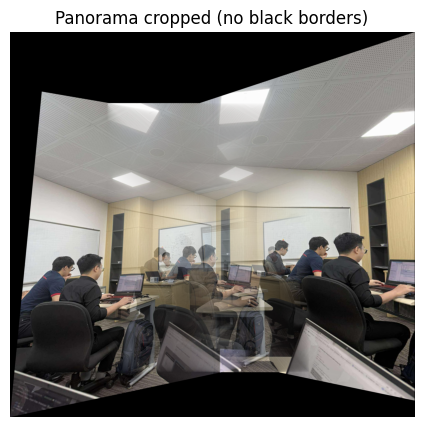

In [19]:
# Cell 11: Hàm tự động crop vùng valid từ panorama (loại bỏ phần đen)
def crop_black_border(panorama):
    """
    Nhận đầu vào panorama (ảnh kết quả), 
    tìm bounding box của vùng không phải tất cả 3 channel =0, rồi crop.
    """
    gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    # Tìm tất cả pixel > 0
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = panorama[y:y+h, x:x+w]
    return cropped

# Crop & hiển thị
panorama_cropped = crop_black_border(panorama)
plt.figure(figsize=(10,5))
plt.title("Panorama cropped (no black borders)")
plt.axis('off')
plt.imshow(cv2.cvtColor(panorama_cropped, cv2.COLOR_BGR2RGB))
plt.show()
